<a href="https://colab.research.google.com/github/Nico-lly/Coursera_Capstone/blob/main/Coursera_capstone%20week%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##This notebook will be used for documentation and execution of Coursera aplied data science capstone activities about Segmenting and Clustering Neighborhoods in Toronto.






* **Use pandas, or the BeautifulSoup package, or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe.**

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(url)
soup = BeautifulSoup(html.text, 'html.parser')

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
print('Data frame shape:',df.shape, '\n')
df.head()

Data frame shape: (103, 3) 



,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


* **Get the latitude and the longitude coordinates of each neighborhood from the csv file, that has the geographical coordinates of each postal code, and include as a column in the last dataframe.**

In [6]:
coordinates = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
print('Data frame shape:', coordinates.shape, '\n')
coordinates.head()

Data frame shape: (103, 3) 



,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Lets remove the space betwen the worlds in first column, and make this columns from both dafaframes have the same name.

In [7]:
coordinates.rename(columns = {'Postal Code' : 'PostalCode'}, inplace = True)

In [8]:
coordinates.columns

Index(['PostalCode', 'Latitude', 'Longitude'], dtype='object')

In [9]:
Toronto_df = pd.merge(df,coordinates, how = 'inner', on = 'PostalCode')
Toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


* **Explore and cluster the neighborhoods in Toronto.**



We will analyse only Downtown Toronto avenues, them lets make a query, save it as a new dataframe and reset the index.

In [10]:
down_toronto = Toronto_df[Toronto_df['Borough'] == 'Downtown Toronto'].reset_index()
down_toronto

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
5,25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
6,30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
7,36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
8,42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576
9,48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817


Lets create a function to get the Venues and Venues Category from foursquare API, and create a new df with a merge into our Toronto dataframe.

For a foursquare search, is needed declare your respective credentials.

In [11]:
CLIENT_ID = 'YD4RLCE3VNOTOJWKJJIYN50X0Z5QE22QMBLORO11QUENUYMC'
CLIENT_SECRET = 'WJ2KAZX5X5VNZL3K5TUQOXNBEYBXMLODJTABKX330DXYYTAR' 
VERSION = '20180605'
LIMIT = 100 

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    nearby_venues = pd.DataFrame()
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}'
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    for lists in venues_list:
      for item in lists:
        df1 = pd.DataFrame(item).T
        df1.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        nearby_venues = pd.concat([nearby_venues, df1], ignore_index = True)
    
    return(nearby_venues)

In [13]:
dtoronto_venues = getNearbyVenues(down_toronto['Neighborhood'], down_toronto['Latitude'], down_toronto['Longitude'])

In [14]:
print('dtoronto_venues shape: ', dtoronto_venues.shape)
dtoronto_venues.head()


dtoronto_venues shape:  (1099, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.6543,-79.3606,Roselle Desserts,43.6534,-79.362,Bakery
1,"Regent Park, Harbourfront",43.6543,-79.3606,Tandem Coffee,43.6536,-79.3618,Coffee Shop
2,"Regent Park, Harbourfront",43.6543,-79.3606,Cooper Koo Family YMCA,43.6532,-79.358,Distribution Center
3,"Regent Park, Harbourfront",43.6543,-79.3606,Body Blitz Spa East,43.6547,-79.3599,Spa
4,"Regent Park, Harbourfront",43.6543,-79.3606,Impact Kitchen,43.6564,-79.357,Restaurant


In [15]:
print('Unique categories: ', len(dtoronto_venues['Venue Category'].unique()))

Unique categories:  205


Preparation for clusterization with kmeans, geting the venues catecories as a one hot in code columns, and add a neghborhood column.

In [16]:
toronto_onehot = pd.get_dummies(dtoronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = dtoronto_venues['Neighborhood']
#toronto_onehot.set_index(dtoronto_venues['Neighborhood'], inplace = True)
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
#toronto_onehot = toronto_onehot[fixed_columns]


In [17]:
#toronto_onehot.reset_index()
toronto_onehot.head()

,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,...,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Candy Store,...,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.017241,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.017241,0.034483,0.000000,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.017241,0.017241,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.017241,0.0000,...,0.0,0.000000,0.00000,0.000000,0.017241,0.0,0.000000,0.034483,0.0,0.017241,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017241,0.0,0.017241,0.000000,0.0,0.000000,0.0,0.017241,0.0,0.0,0.0,0.017241,0.000000,0.000000,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.066667,0.066667,0.133333,0.133333,0.133333,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.066667,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.066667,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.066667,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.015625,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.000000,0.015625,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.015625,0.0,0.000000,0.0,0.031250,0.0,0.031250,0.000000,0.0,0.046875,0.0000,...,0.0,0.000000,0.03125,0.000000,0.062500,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.015625,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.015625,0.0,0.000000,0.0,0.0,0.0,0.015625,0.000000,0.000000,0.0,0.0,0.015625,0.0,0.0,0.015625,0.0,0.000000,0.015625
3,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0625,0.0,0.0625,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.187500,0.0625,...,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.013333,0.0,0.000000,0.000000,0.000000,0.013333,0.0,0.013333,0.0,0.013333,0.0,0.013333,0.013333,0.0,0.013333,0.0000,...,0.0,0.013333,0.00000,0.013333,0.000000,0.0,0.013333,0.000000,0.0,0.000000,0.0,0.013333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.013333,0.013333,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.013333,0.013333,0.013333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.013333,0.026667


Get the top 10 most common venues from each neighborhood.


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery,Restaurant,Pharmacy,Beer Bar,Café
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Bar,Harbor / Marina,Plane,Coffee Shop,Rental Car Location,Sculpture Garden
2,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Yoga Studio,Modern European Restaurant,Juice Bar
3,Christie,Grocery Store,Café,Park,Baby Store,Restaurant,Candy Store,Athletics & Sports,Nightclub,Italian Restaurant,Coffee Shop
4,Church and Wellesley,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Hotel,Pub,Men's Store,Mediterranean Restaurant,Yoga Studio,Fast Food Restaurant


Discovery the best number of clusters for kmeans aplication


In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

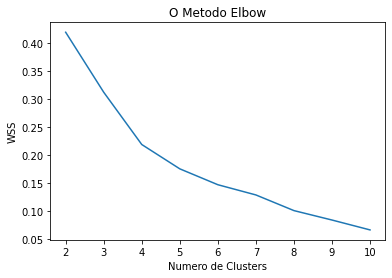

In [22]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
wcss = []
 
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i, random_state=0)
  kmeans.fit(toronto_grouped_clustering)
  wcss.append(kmeans.inertia_) 

plt.plot(range(2, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS')
plt.show()


The bests numbers of clusters acord to our elbow evalulation is 4 or 5. I will try 5 clusters because if a line was draw from first point until the last, looks like the point 5 is closest to this line than point 4.


In [23]:
kclusters = 5 
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10] 

array([0, 3, 0, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [24]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge venues_sorted with down_toronto to add latitude/longitude for each neighborhood
Toronto_merged = down_toronto
Toronto_merged = Toronto_merged.join(venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head()

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Yoga Studio,Event Space,Performing Arts Venue
1,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Bookstore,Hotel,Pizza Place
2,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Beer Bar,Cosmetics Shop,Gastropub,Italian Restaurant,Hotel,American Restaurant,Department Store
3,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery,Restaurant,Pharmacy,Beer Bar,Café
4,24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Yoga Studio,Modern European Restaurant,Juice Bar


Lets finaly plot our folium map

In [28]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

Firs lets set our latitude longitude from Toronto city, because geopy doen't work.

In [26]:
toronto_latitude = 43.6532
toronto_longitude = -79.3832

In [33]:
# create map of Toronto using latitude and longitude values
map_downtoronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_downtoronto)
       
map_downtoronto